# Agente Imobiliário Personalizado

# Personalized Real Estate Agent

Neste projeto você será desafiado a criar uma experiência personalizada para cada comprador, buscando imóveis em anúncios que adequam às suas preferências, primeiramente você irá usar um LLM para gerar descrições realistas de imóveis, e gerar um arquivo txt com essas informações, depois irá combinar o poder do Langchain e um banco de dados vetorial para armazenar os embeddings desses dados. o próximo passo será procurar nessa base de dados os anúncios que melhor se adequam, com base na consulta do usuário. Finalmente com o poder da I.A generativa, você irá usar o stable diffusion para criar imagens realistas desses imóveis, baseado nos dados de cada anúncio.

In this project, you will be challenged to create a personalized experience for each buyer, searching for properties in ads that suit their preferences. First, you will use an LLM to generate realistic property descriptions and generate a txt file with this information. Then, you will combine the power of Langchain and a vector database to store the embeddings of this data. The next step will be to search this database for the ads that best fit, based on the user's query. Finally, with the power of generative AI, you will use stable diffusion to create realistic images of these properties, based on the data from each ad.

## Instala os Pacotes Necessários

## Install the Required Packages

In [1]:
!pip install diffusers
!pip install torch
!pip install ipython
!pip install -U accelerate
!pip install langchain==0.0.305
!pip install openai==0.28.1
!pip install pydantic>=1.10.12
!pip install pytest>=7.4.0
!pip install sentence-transformers>=2.2.0
!pip install transformers>=4.31.0
!pip install chromadb==0.4.12
!pip install jupyter==1.0.0
!pip install tiktoken==0.4.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

## Importa as Bibliotecas a Serem Utilizadas

## Import the Libraries to be Used

In [2]:
from langchain.chat_models import ChatOpenAI
from langchain.llms import OpenAI
from diffusers import DiffusionPipeline, AutoPipelineForText2Image
from accelerate import Accelerator
from langchain.document_loaders.csv_loader import CSVLoader
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.text_splitter import CharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
from langchain import LLMChain
from langchain.chains.question_answering import load_qa_chain
from google.colab import drive, files
import torch
import json
import PIL
import pandas as pd
import re
import os

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


## Carrega os Modelos

## Load the Models

In [3]:
os.environ['OPENAI_API_KEY']= "Put Your Key Here"
accelerator = Accelerator()

device = accelerator.device
device

device(type='cuda')

In [4]:
model_name = 'gpt-4o'

llm = ChatOpenAI(model_name=model_name, temperature=0.8, max_tokens=2000)

In [5]:
pipe = AutoPipelineForText2Image.from_pretrained(
    "stabilityai/sdxl-turbo",
    torch_dtype=torch.float16,
    variant="fp16"
).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.78k [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

## Gerando o arquivo 'Listagens.txt' contendo as descrições dos anúncios de imóveis

## Generating the file 'Listagens.txt' containing the descriptions of the real estate advertisements

Agora utilizando o ChatGPT4-o iremos criar descrições detalhadas de anúncios de imóveis no Brasil, e armazená-las em um arquivo chamado 'Listagens.txt' contendo essas informações.

Now using ChatGPT4-o we will create detailed descriptions of real estate listings in Brazil, and store them in a file called 'Listagens.txt' containing this information.

In [6]:
number=50
query ="""
Generate 50 extremely realistic descriptions of properties in Brazil, containing the following complete information:

1)Price (in R$)
2)Complete address (can be anywhere in Brazil) with neighborhood, street, zip code, city and state
3)Type: House, apartment, kitinet, flat etc...
4)Architectural style, e.g. European, Classical, Romanesque, Gothic, Baroque, Neoclassical, Beaux Arts, Art Nouveau, Art Deco, etc.
5)Number of rooms
6)Number of bathrooms
7)Number of parking spaces in the garage
8)House area (in square meters)
9)More details such as: swimming pool, barbecue, sauna, leisure area (cinuca table, table tennis, football field, etc.), gym, air conditioning, 24-hour concierge, Wi-Fi, cable TV, suite, hydromassage etc...
10)Description of the property
11)Description of the neighborhood

Follow the example model below, in python dictionary format, do not use NaN values, put @# at the end of each one:

{"Price": "R$800,000","Address": "Street: Antônio Campos, number:37, neighborhood: Carvalhos Verdes, CEP:37650-000, city:Camanducaia, state:Minas Gerais, Country:Brazil", " Type": "House","Architectural style": "European","Number of bedrooms": "3","Number of bathrooms": "2","Number of parking spaces": "2", "Size of the house": "2,000 m²","Additional information": "swimming pool, sauna, barbecue, 24-hour concierge and 1 suite.","Property description": "Welcome to this ecological oasis located in the heart of Carvalhos Verdes This charming 3-bedroom, 2-bathroom home boasts energy-efficient features like solar panels and a well-insulated structure that floods the living spaces, highlighting the beautiful wood floors and eco-friendly finishes throughout the kitchen and dining area. to a large backyard with vegetable garden, perfect for the ecologically conscious family. Embrace sustainable living without compromising style in this gem of Carvalhos Verdes.","Neighborhood description": "Carvalhos Verdes is a close-knit neighborhood, environmentally conscious community, with access to organic grocery stores, community gardens and bike paths. Take a walk around the Parque Carvalhos Verdes neighborhood or have a coffee at the cozy Café Carvalhos Verdes. With easy access to public transport and cycle paths, getting around is very easy."}@#
"""

In [ ]:
full_list=[]

for i in range(10):
  property_description1 = llm.predict(query)
  property_description=re.sub("python|```|\n","",property_description1)
  list_property=property_description.split("@#")[:number]
  list_property=[obj+'"}' if obj[-1]!='}' else obj for obj in list_property]
  try:
    full_list+=[json.loads(obj) for obj in list_property]
  except:
    pass

In [ ]:
len(full_list)

41

In [ ]:
for i in range(1,len(full_list)+1):
  full_list[i-1]["Property_ID"]=i

df_property=pd.DataFrame(full_list)
df_property.to_csv("Listagens.txt", sep=",", index=False)
files.download('Listagens.txt')

In [9]:
df_property=pd.read_csv("Listagens.txt", sep=",")
df_property.head(10)

,Price,Address,Type,Architectural style,Number of bedrooms,Number of bathrooms,Number of parking spaces,Size of the house,Additional information,Property description,Neighborhood description,Property_ID
0,"R$1,250,000","Street: Rua das Flores, number:100, neighborho...",Apartment,Neoclassical,4.0,3.0,2.0,180 m²,"swimming pool, gym, sauna, 24-hour concierge, ...",Discover luxury living in this exquisite neocl...,Jardim Botanico is one of Rio de Janeiro's mos...,1
1,"R$850,000","Street: Rua dos Coqueiros, number:45, neighbor...",House,Modern,3.0,2.0,1.0,300 m²,"swimming pool, barbecue, air conditioning, Wi-...",This modern 3-bedroom house in Boa Viagem offe...,"Boa Viagem is a bustling, upscale neighborhood...",2
2,"R$600,000","Street: Avenida Paulista, number:1500, neighbo...",Flat,Art Deco,2.0,2.0,1.0,120 m²,"gym, 24-hour concierge, Wi-Fi, cable TV, 1 suite.",Live in style in this charming Art Deco flat l...,Bela Vista is at the heart of São Paulo's cult...,3
3,"R$950,000","Street: Rua das Palmeiras, number:200, neighbo...",House,Colonial,4.0,3.0,2.0,400 m²,"swimming pool, barbecue, leisure area, air con...",Experience the charm of this colonial-style ho...,Lagoa da Conceição is a picturesque neighborho...,4
4,"R$1,500,000","Street: Avenida Atlântica, number:1800, neighb...",Penthouse,Art Nouveau,3.0,3.0,2.0,250 m²,"swimming pool, gym, sauna, 24-hour concierge, ...",This luxurious Art Nouveau penthouse in Copaca...,Copacabana is one of Rio de Janeiro's most ico...,5
5,"R$700,000","Street: Rua das Acácias, number:50, neighborho...",Apartment,Beaux Arts,3.0,2.0,1.0,140 m²,"gym, Wi-Fi, cable TV, 1 suite.",This elegant Beaux Arts apartment in Jardim Am...,Jardim América is one of São Paulo's most pres...,6
6,"R$950,000","Street: Rua do Sol, number:75, neighborhood: C...",House,Baroque,5.0,4.0,3.0,500 m²,"swimming pool, barbecue, leisure area, air con...",This stunning Baroque-style house in Centro Jo...,"Centro is the historic heart of João Pessoa, k...",7
7,"R$1,100,000","Street: Rua das Pedras, number:15, neighborhoo...",Beach House,Tropical,4.0,4.0,2.0,350 m²,"swimming pool, barbecue, leisure area, air con...",This beautiful tropical-style beach house in P...,NaN,8
8,"R$1,500,000","Street: Rua das Palmeiras, number: 200, neighb...",Apartment,Art Deco,4.0,3.0,2.0,220 m²,"swimming pool, gym, 24-hour concierge, Wi-Fi, ...",This stunning 220 m² Art Deco apartment in Jar...,Jardim Paulista is a prestigious and vibrant n...,9
9,"R$950,000","Street: Avenida Atlântica, number: 1550, neigh...",Flat,Modernist,2.0,2.0,1.0,90 m²,"24-hour concierge, swimming pool, gym, Wi-Fi, ...","Located on Avenida Atlântica, this 90 m² moder...",Copacabana is one of Rio de Janeiro's most ico...,10


In [11]:
#df_property.drop([' Type'] , axis=1, inplace=True)
df_property.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Price                     41 non-null     object 
 1   Address                   41 non-null     object 
 2   Type                      32 non-null     object 
 3   Architectural style       40 non-null     object 
 4   Number of bedrooms        40 non-null     float64
 5   Number of bathrooms       40 non-null     float64
 6   Number of parking spaces  40 non-null     float64
 7   Size of the house         40 non-null     object 
 8   Additional information    40 non-null     object 
 9   Property description      39 non-null     object 
 10  Neighborhood description  36 non-null     object 
 11  Property_ID               41 non-null     int64  
dtypes: float64(3), int64(1), object(8)
memory usage: 4.0+ KB


## Utilizando o Langchain e o Banco de Dados Vetorial ChromaDB para Armazenar os Embeddings Contendo as Informações Semânticas das Descrições dos Anúncios Armazenados Anteriormente em 'Listagens.txt'.

## Using Langchain and the ChromaDB Vector Database to Store Embeddings Containing the Semantic Information of the Ad Descriptions Previously Stored in 'Listagens.txt'.

In [12]:
loader = CSVLoader(file_path='./Listagens.txt')
docs = loader.load()

splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
split_docs = splitter.split_documents(docs)

embeddings = OpenAIEmbeddings()

db = Chroma.from_documents(split_docs, embeddings)

## Cria a Consulta do Usuário Especificando Suas Preferências do Imóvel Procurado

## Creates the User Query Specifying Your Preferences for the Property Searched

In [13]:
context = """
Based on the buyer's preferences below, add more detailed information to highlight the characteristics sought, in order to increase the description of the property ads, and personalize the listing, be creative but without changing the factual information:
"""

query = """
Price: <= R$500
Address: in the state of Espírito Santo or Paraná
Type: Home, Kitinet or Apartment
Architectural style: Contemporary or Minimalist
Number of bedrooms: between 2 and 3
Number of bathrooms: at least 1
Number of parking spaces: over 1
House size: over 40 m²
Additional information: 24-hour concierge, Wi-Fi and cable TV.
Property description: preferably close to the beach, lounge area or gym.
Neighborhood description: Ideal for those who like to enjoy nightlife, with bars, pubs, good restaurants, and preferably close to many cultural attractions.
"""

## Realiza a Consulta no Bando de Dados Vetorial, Encontrando as 3 Ocorrencias Mais Relevantes, ou Seja, Que Mais Se Adequam a Descrição do Usuário

## Performs a Query in the Vector Database, Finding the 3 Most Relevant Occurrences, That is, Those That Best Fit the User's Description

In [14]:
similar_docs = db.similarity_search(query, k=3)

In [15]:
similar_docs

[Document(page_content='Price: R$500,000\nAddress: Street: Rua Bela Vista, number: 78, neighborhood: Praia do Canto, CEP: 29055-180, city: Vitória, state: Espírito Santo, Country: Brazil\nType: Apartment\nArchitectural style: Contemporary\nNumber of bedrooms: 2.0\nNumber of bathrooms: 2.0\nNumber of parking spaces: 1.0\nSize of the house: 95 m²\nAdditional information: balcony, 24-hour concierge, Wi-Fi, cable TV, 1 suite.\nProperty description: This contemporary 2-bedroom apartment in Praia do Canto offers a blend of style and comfort. The living room opens to a balcony with\nNeighborhood description: \nProperty_ID: 24', metadata={'row': 23, 'source': './Listagens.txt'}),
 Document(page_content="Price: R$530,000\nAddress: Street: Rua das Flores, number: 112, neighborhood: Centro, CEP: 80020-040, city: Curitiba, state: Paraná, Country: Brazil\nType: Kitinet\nArchitectural style: Minimalist\nNumber of bedrooms: 1.0\nNumber of bathrooms: 1.0\nNumber of parking spaces: 1.0\nSize of the hou

## Fornece os Dados Recuperados Anteriormente ao LLM e Solicita que Ele Faça o Aumento dos Dados, ou Seja, Adicione Mais Informações aos Dados, Sem Alterar as Descrições Fatuais dos Anúncios e Apresenta os Resultados ao Usuário Final

## Provides Previously Retrieved Data to LLM and Requests It to Augment the Data, That is, Add More Information to the Data, Without Changing the Factual Descriptions of the Ads and Presents the Results to the End User

In [16]:
prompt = PromptTemplate(template="Context: {context}\n{query}",input_variables=["context","query"])
chain = load_qa_chain(llm, prompt = prompt, chain_type="stuff")
response = chain.run(input_documents=similar_docs, query = context)
print(response)

### Buyer Preferences:
- Looking for a mix of comfort and modern amenities.
- Prefers vibrant neighborhoods with easy access to public amenities.
- Enjoys contemporary or minimalist designs.
- Values additional services such as concierge and communal facilities.
- Interested in properties suitable for single occupants, couples, or small families.
- Looking for options with practical space utilization and modern amenities.

---

#### Property_ID: 24

**Price:** R$500,000  
**Address:** Rua Bela Vista, 78, Praia do Canto, Vitória, Espírito Santo, Brazil  
**Type:** Apartment  
**Architectural Style:** Contemporary  
**Number of Bedrooms:** 2.0  
**Number of Bathrooms:** 2.0  
**Number of Parking Spaces:** 1.0  
**Size of the House:** 95 m²  
**Additional Information:** Balcony, 24-hour concierge, Wi-Fi, cable TV, 1 suite.  

**Property Description:**  
This contemporary 2-bedroom apartment in the coveted Praia do Canto neighborhood is the epitome of style and comfort. Boasting a generous

## Gera Imagens Fictícias dos Imóveis, Usando o Stable Diffusion, Com Base Nos Anúncios Que Melhor se Adequam às Preferências da Consulta do Usuário

## Generates Fictional Property Images Using Stable Diffusion Based on Ads That Best Match User Query Preferences

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['street : rua bela vista, number : 7 8, neighborhood : praia do canto, cep : 2 9 0 5 5 - 1 8 0, city : vitória, state : espírito santo, country : brazil type : apartment architectural style : contemporary number of bedrooms : 2. 0 number of bathrooms : 2. 0 number of parking spaces : 1. 0 size of the house : 9 5 m ² additional information : balcony, 2 4 - hour concierge, wi - fi, cable tv, 1 suite. property description : this contemporary 2 - bedroom apartment in praia do canto offers a blend of style and comfort. the living room opens to a balcony with neighborhood description : property _ id : 2 4']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['street : rua bela vista, number : 7 8, neighborhood : praia do canto, cep : 2 9 0 5 5 - 1 8 0, city : vitória, state : espírito santo, country : brazil type : apartment architectural

  0%|          | 0/1 [00:00<?, ?it/s]

Property Identifier: 24:


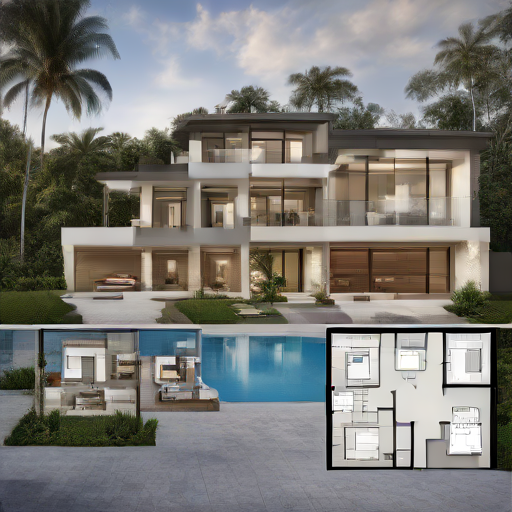

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["street : rua das flores, number : 1 1 2, neighborhood : centro, cep : 8 0 0 2 0 - 0 4 0, city : curitiba, state : paraná, country : brazil type : kitinet architectural style : minimalist number of bedrooms : 1. 0 number of bathrooms : 1. 0 number of parking spaces : 1. 0 size of the house : 4 5 m ² additional information : 2 4 - hour concierge, wi - fi, cable tv, air conditioning. property description : ideal for young professionals or students, this minimalist kitinet in curitiba's centro offers a compact yet efficient living space. the open - plan layout maximizes functionality and comfort, featuring a well - designed kitchen and a modern bathroom. neighborhood description : centro is the vibrant heart of curitiba, offering a mix of business, cultural, and recreational opportunities. the area is known for its excellent public transportation, green spaces, and bustling street life,

  0%|          | 0/1 [00:00<?, ?it/s]

Property Identifier: 37:


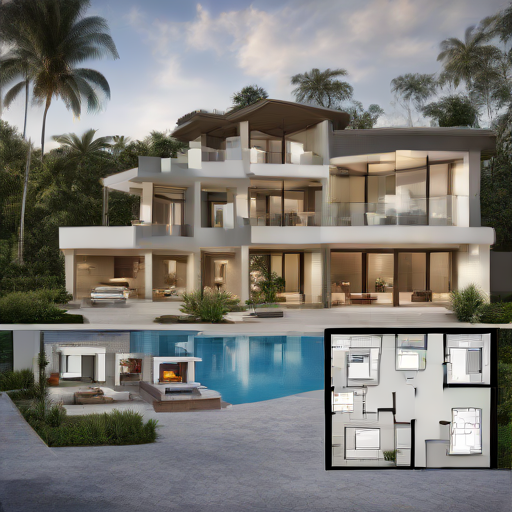

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["street : rua das flores, number : 1 2 3, neighborhood : batel, cep : 8 0 4 2 0 - 0 9 0, city : curitiba, state : paraná, country : brazil type : kitinet architectural style : minimalist number of bedrooms : 1. 0 number of bathrooms : 1. 0 number of parking spaces : 1. 0 size of the house : 4 5 m ² additional information : 2 4 - hour concierge, wi - fi, cable tv, gym. property description : ideal for single occupants or couples, this minimalist kitinet in batel maximizes its 4 5 m ² efficiently. the open - plan layout includes a well - equipped kitchenette, a cozy living area, and a stylish bathroom. the building offers amenities such as a gym and 2 4 - hour concierge services. neighborhood description : batel is one of curitiba's most sought - after neighborhoods. known for its vibrant nightlife, excellent restaurants, and upscale shopping, batel also offers good public transport co

  0%|          | 0/1 [00:00<?, ?it/s]

Property Identifier: 22:


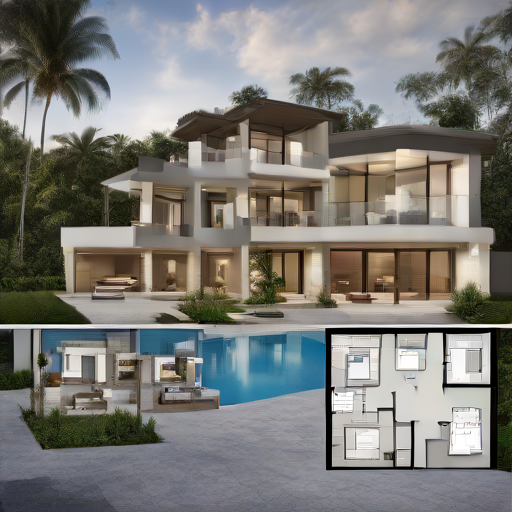

In [49]:
prompt = "Create a photorealistic image, of the front of a property, and another of the floor plan, without artifacts, without distortion, change the color of the house and the environment, vary the angle of each image, intricate details, National Geographic, 8k high resolution, be faithful to the following description below:\n\n{}\n\n"

for obj in similar_docs:
  property_description=obj.page_content
  Property_ID=int(re.findall(r"Property_ID:\s*\d+\s*",property_description)[0].replace("Property_ID:",""))
  #print(prompt.format(property_description))
  rand_gen = torch.manual_seed(423122981)
  images = pipe(prompt=prompt.format(property_description),num_inference_steps=1,guidance_scale=1.0,negative_prompt=["overexposed", "underexposed"],generator=rand_gen).images
  print(f"Property Identifier: {Property_ID}:")
  for image in images:
    display(image)

